# Exercise 3: Representation learning for bone fractures

In this assignment you are required to implement a bone fracture xray classification task utilizing a SSL
approach with the following data set: https://stanfordmlgroup.github.io/competitions/mura/


In [ ]:
from pathlib import Path
import os
import pandas as pd
import seaborn as sns
import random
from google.colab import drive
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Check if GPU is available
if tf.test.gpu_device_name():
    print('GPU:', tf.test.gpu_device_name())
else:
    print("GPU not found. Using CPU...")

GPU not found. Using CPU...


## Import Data

In [ ]:
drive.mount("/content/drive", force_remount=True)
%cd /content/drive/MyDrive/AI_for_Healthcare/Exercise3/
%ls

Mounted at /content/drive
/content/drive/MyDrive/AI_for_Healthcare/Exercise3
 baseline_test_df_all.csv    hw3_results_hes_bs8/
 baseline_train_df_all.csv  'IDC_AI for healthcare_2023_Ex3.pdf'
 HW3-Baseline.ipynb          MURA-v1.1/
 HW3_Evaluation.ipynb       'Notes for Report.gdoc'
 HW3-Model.ipynb             Report.gdoc
 hw3_results_full_bs8/       VM_RESULTS/


In [ ]:
# random.seed(42)

# # def load_data(data_dir):

#   relevant_categories = ["XR_ELBOW", "XR_HAND", "XR_SHOULDER"]

#   dataset = []
#   for category in os.listdir(data_dir):

#     if category in relevant_categories: # Only for relevant categories
#       category_path = os.path.join(data_dir, category)

#       normal_patients, abnormal_patients = [], []

#       for patient in os.listdir(category_path): # Iterate through patients
#         patient_path = os.path.join(category_path, patient)

#         for study_type in os.listdir(patient_path): # Iterate through pos, nega

#           if "positive" in study_type:
#             abnormal_patients.append(patient_path)
#           elif "negative" in study_type:
#             normal_patients.append(patient_path)


#       patients = normal_patients + abnormal_patients
#       random.shuffle(patients)  # Shuffle the patients

#       for patient_path in patients:
#         for study_type in os.listdir(patient_path):
#           study_path = os.path.join(patient_path, study_type)

#           if "positive" in study_type:
#             label = "abnormal"
#           elif "negative" in study_type:
#             label = "normal"

#           for image in os.listdir(study_path):
#             image_path = os.path.join(study_path, image)
#             dataset.append(
#                 {
#                     'label': label,
#                     'body_part': category,
#                     'image_path': image_path
#                 }
#             )

#   return pd.DataFrame(dataset)

# mura_dir = '/content/drive/MyDrive/AI_for_Healthcare/Exercise3/MURA-v1.1/train'
# train_df = load_data(mura_dir)
# print(train_df.head())

# mura_dir = '/content/drive/MyDrive/AI_for_Healthcare/Exercise3/MURA-v1.1/valid'
# test_df = load_data(mura_dir)
# print(test_df.head())

In [ ]:
# train_df.to_csv("baseline_train_df_all.csv", index=False)
# test_df.to_csv("baseline_test_df_all.csv", index=False)

In [ ]:
train_df_path = '/content/drive/MyDrive/AI_for_Healthcare/Exercise3/baseline_train_df_all.csv'
train_df = pd.read_csv(train_df_path)

test_df_path = '/content/drive/MyDrive/AI_for_Healthcare/Exercise3/baseline_test_df_all.csv'
test_df = pd.read_csv(test_df_path)


In [ ]:
train_df

,label,body_part,image_path
0,normal,XR_SHOULDER,/content/drive/MyDrive/AI_for_Healthcare/Exerc...
1,normal,XR_SHOULDER,/content/drive/MyDrive/AI_for_Healthcare/Exerc...
2,normal,XR_SHOULDER,/content/drive/MyDrive/AI_for_Healthcare/Exerc...
3,normal,XR_SHOULDER,/content/drive/MyDrive/AI_for_Healthcare/Exerc...
4,normal,XR_SHOULDER,/content/drive/MyDrive/AI_for_Healthcare/Exerc...
...,...,...,...
20416,abnormal,XR_HAND,/content/drive/MyDrive/AI_for_Healthcare/Exerc...
20417,abnormal,XR_HAND,/content/drive/MyDrive/AI_for_Healthcare/Exerc...
20418,normal,XR_HAND,/content/drive/MyDrive/AI_for_Healthcare/Exerc...
20419,normal,XR_HAND,/content/drive/MyDrive/AI_for_Healthcare/Exerc...


## Data Exploration

All steps must include a description of data exploration: data distribution, visualization, thorough evaluation, visualization of results, demonstration of good and bad results

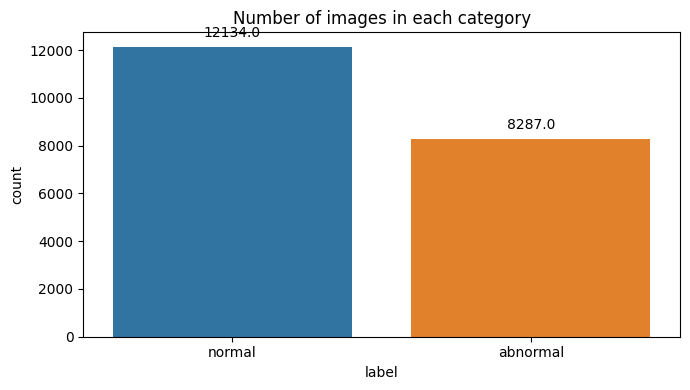

In [ ]:
# Count the number of images in each category
category_counts = train_df.groupby('label').size()
plt.figure(figsize=(7, 4))
ax1 = sns.countplot(x='label', data=train_df)
plt.title("Number of images in each category")

# Add labels
for p in ax1.patches:
    ax1.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.tight_layout()
plt.show()

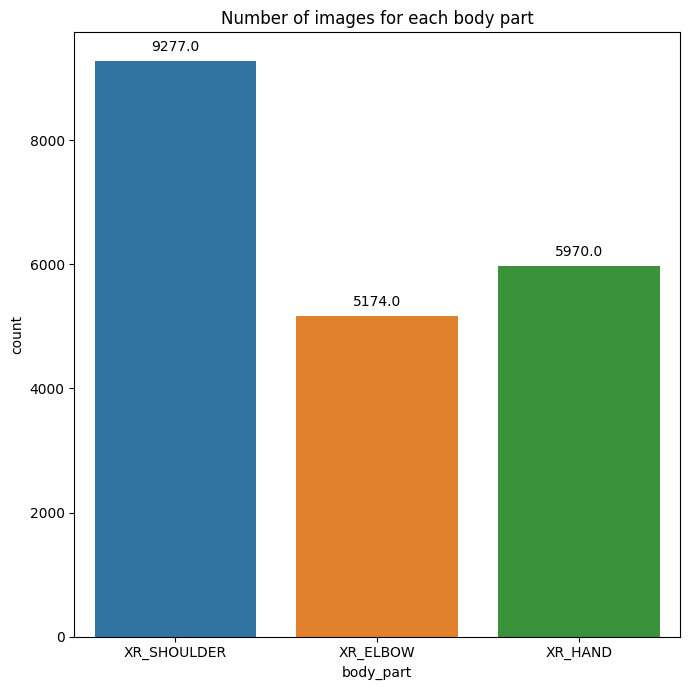

In [ ]:
# Count the number of images for each body part
body_part_counts = train_df.groupby('body_part').size()
plt.figure(figsize=(7, 7))
ax2 = sns.countplot(x='body_part', data=train_df)
plt.title("Number of images for each body part")

# Add labels
for p in ax2.patches:
    ax2.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.tight_layout()
plt.show()

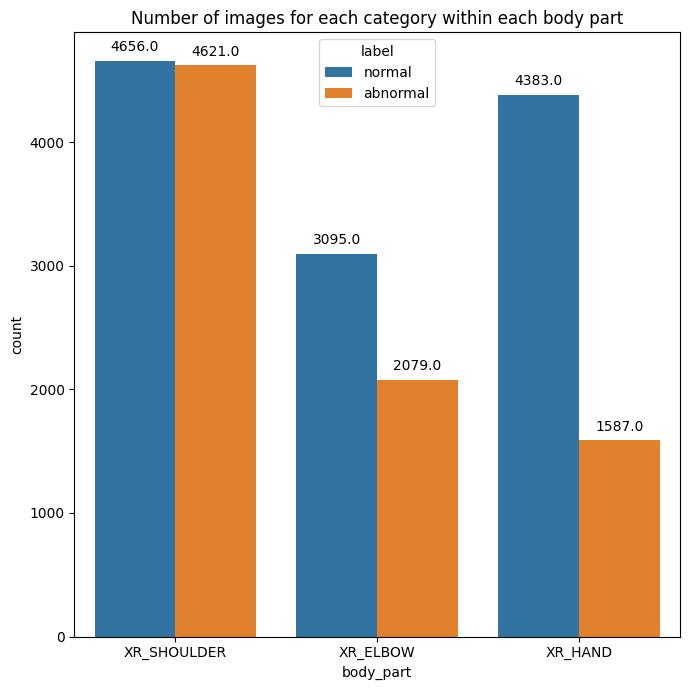

In [ ]:
# Dist of labels within each body part, you can do a groupby on both columns
label_body_part_counts = train_df.groupby(['body_part', 'label']).size()
plt.figure(figsize=(7, 7))
ax3 = sns.countplot(x='body_part', hue='label', data=train_df)
plt.title("Number of images for each category within each body part")

# Add labels
for p in ax3.patches:
    ax3.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.tight_layout()
plt.show()

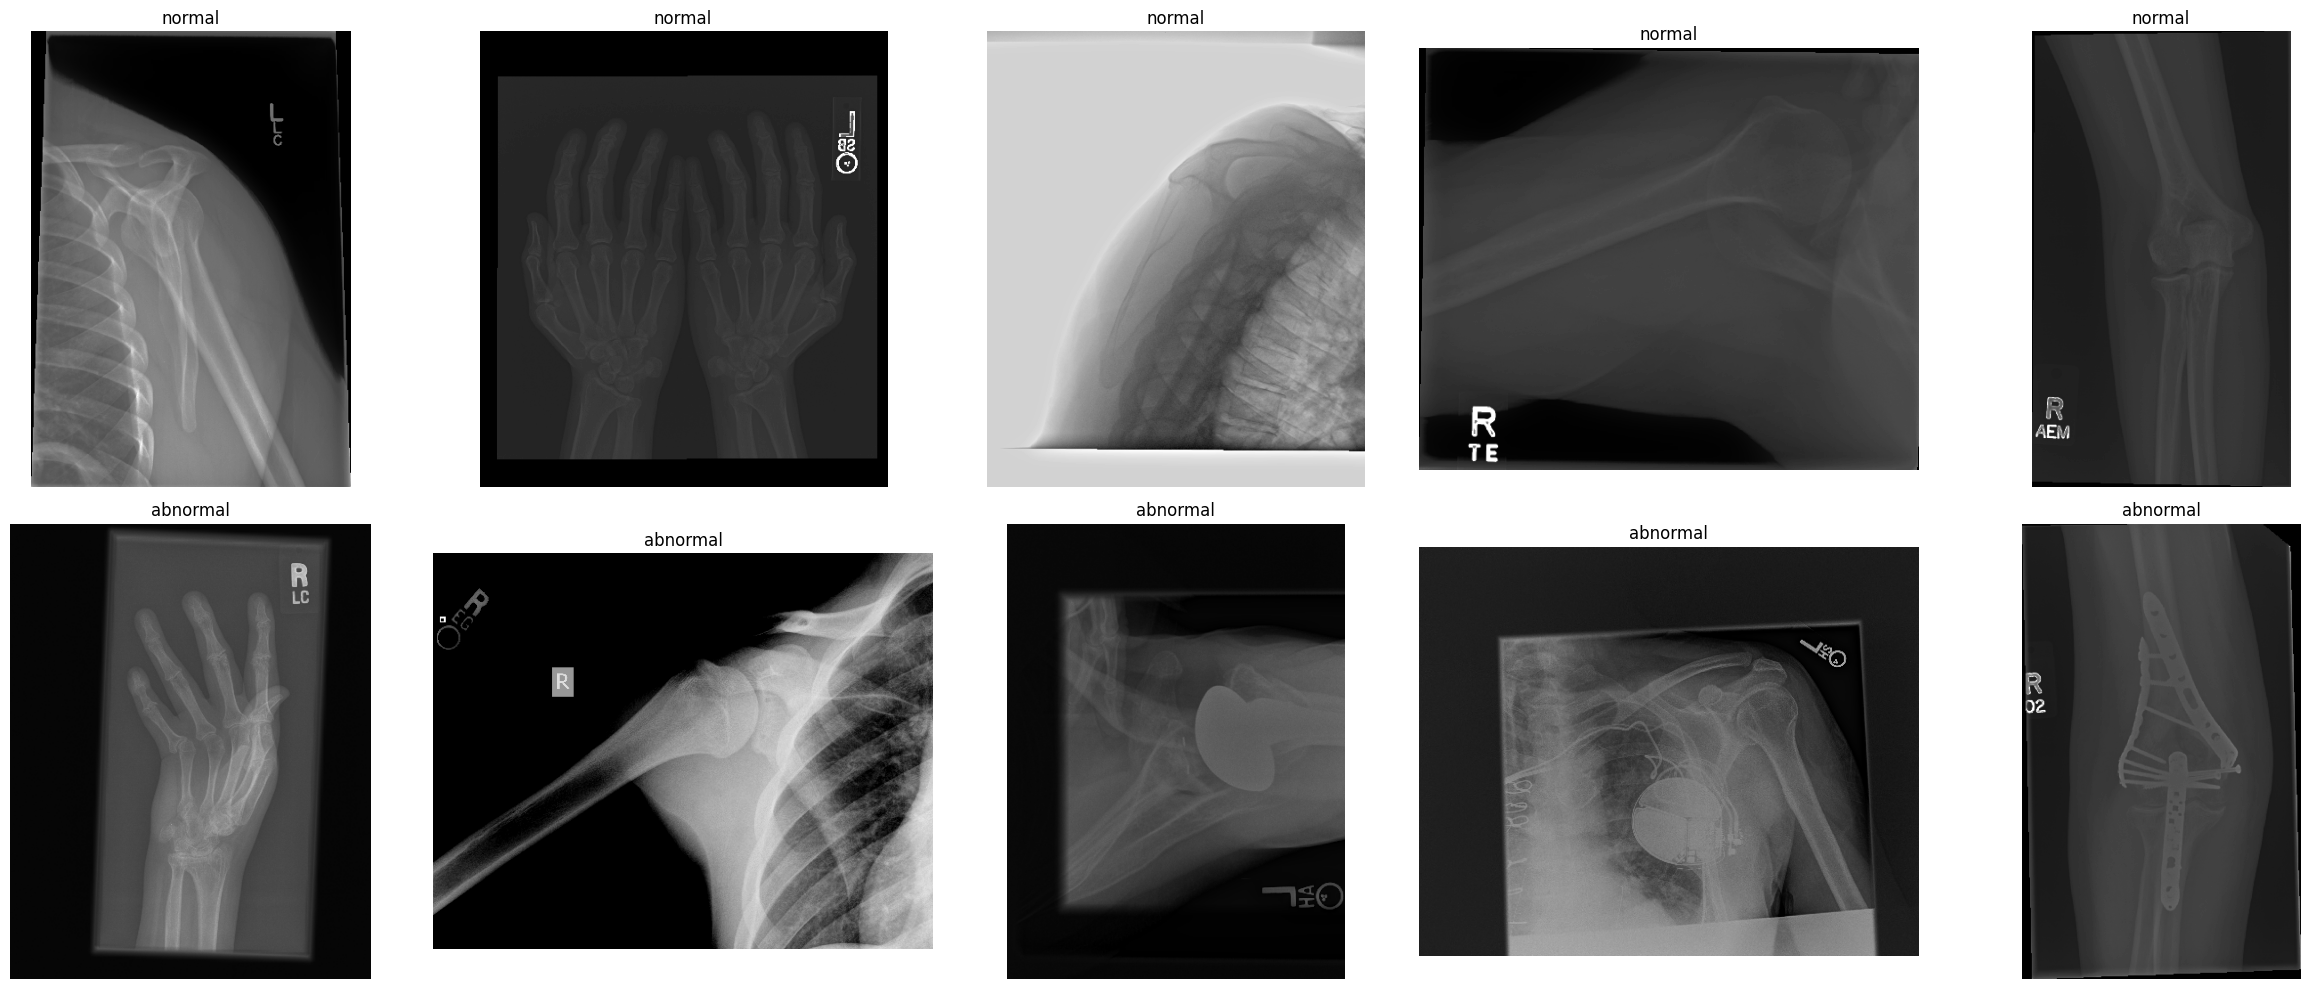

In [ ]:
def display_sample_images(df, num_images=5):

    labels = df['label'].unique()

    # Set the figure size according to the number of images and labels
    fig, axes = plt.subplots(len(labels), num_images, figsize=(5 * num_images, 5 * len(labels)))

    # Get a sample of images from each category
    for i, label in enumerate(labels):
        sample_images = df[df['label'] == label].sample(num_images)

        for j, (idx, row) in enumerate(sample_images.iterrows()):
            img = Image.open(row['image_path'])
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].set_title(f'{label}')
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

display_sample_images(train_df)